In [ ]:
pip install kaggle


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sqlite3
import pandas as pd
import zipfile

In [ ]:
# Define the path to the zip file and extraction location
zip_path = '/content/drive/MyDrive/Yoni/soccer/soccer.zip'
extract_path = '/content/drive/MyDrive/Yoni/soccer/'

# Extract the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Extraction complete.")


Extraction complete.


In [55]:
# Path to the extracted database file
db_path = '/content/drive/MyDrive/Yoni/soccer/database.sqlite'

# Connect to the database
conn = sqlite3.connect(db_path)

# List all available tables
tables_query = "SELECT name FROM sqlite_master WHERE type='table';"
tables = pd.read_sql_query(tables_query, conn)
print("Available Tables:\n", tables)

# Example: Preview the 'Match' table
match_df = pd.read_sql_query("SELECT * FROM Match LIMIT 5;", conn)
print(match_df.head())

# Close the connection when done
conn.close()


Available Tables:
                 name
0    sqlite_sequence
1  Player_Attributes
2             Player
3              Match
4             League
5            Country
6               Team
7    Team_Attributes
   id  country_id  league_id     season  stage                 date  \
0   1           1          1  2008/2009      1  2008-08-17 00:00:00   
1   2           1          1  2008/2009      1  2008-08-16 00:00:00   
2   3           1          1  2008/2009      1  2008-08-16 00:00:00   
3   4           1          1  2008/2009      1  2008-08-17 00:00:00   
4   5           1          1  2008/2009      1  2008-08-16 00:00:00   

   match_api_id  home_team_api_id  away_team_api_id  home_team_goal  ...  \
0        492473              9987              9993               1  ...   
1        492474             10000              9994               0  ...   
2        492475              9984              8635               0  ...   
3        492476              9991              9998          

This dataset is a rich collection of European football (soccer) data spanning multiple seasons and leagues. It combines match-level information, team and player attributes, and betting odds. The core tables are:

Player: Contains player-level metadata such as player names, physical attributes (height, weight), and birth dates.

Player_Attributes: Stores dynamic player ratings over time, including overall rating, potential, and various skill attributes (e.g., heading accuracy, sprint speed, strength).

Team: Contains basic information about football teams.

Team_Attributes: Tracks evolving team-level characteristics, such as build-up play speed, chance creation, and defense strategies.

Match: The largest and most detailed table, containing match outcomes, team IDs, goals scored, and detailed betting odds from various bookmakers.

League and Country: Provide metadata about the countries and leagues represented in the dataset.

The Match table alone has 115 columns, covering not only match results but also pre-match betting odds from multiple sources, which can be valuable for predictive modeling and betting strategy analysis.

## Which teams have the strongest home advantage?

In [ ]:
# Connect to the database
conn = sqlite3.connect('/content/drive/MyDrive/Yoni/soccer/database.sqlite')

query = """
SELECT
    home.team_long_name AS home_team,
    AVG(m.home_team_goal) AS avg_home_goals,
    AVG(m.away_team_goal) AS avg_away_goals,
    (AVG(m.home_team_goal) - AVG(m.away_team_goal)) AS home_advantage
FROM Match m
JOIN Team home ON m.home_team_api_id = home.team_api_id
GROUP BY home_team
ORDER BY home_advantage DESC
LIMIT 10;
"""

home_advantage_df = pd.read_sql_query(query, conn)
print(home_advantage_df)

conn.close()


          home_team  avg_home_goals  avg_away_goals  home_advantage
0      FC Barcelona        3.256579        0.664474        2.592105
1    Real Madrid CF        3.322368        0.967105        2.355263
2  FC Bayern Munich        2.808824        0.705882        2.102941
3              Ajax        2.647059        0.573529        2.073529
4            Celtic        2.559211        0.578947        1.980263
5        SL Benfica        2.588710        0.661290        1.927419
6          FC Porto        2.379032        0.524194        1.854839
7               PSV        2.720588        0.926471        1.794118
8           Rangers        2.328947        0.736842        1.592105
9    RSC Anderlecht        2.330189        0.745283        1.584906


The result confirms that historically dominant teams like Barcelona, Real Madrid, and Bayern Munich not only win frequently but also have significant home advantages. The home_advantage column shows how much more they score at home compared to what they concede.

## Which Players Have the Highest Overall Rating Over Time?

In [ ]:
conn = sqlite3.connect('/content/drive/MyDrive/Yoni/soccer/database.sqlite')

query = """
SELECT
    p.player_name,
    pa.date,
    pa.overall_rating
FROM Player_Attributes pa
JOIN Player p ON pa.player_api_id = p.player_api_id
WHERE pa.overall_rating IS NOT NULL
ORDER BY pa.overall_rating DESC, pa.date DESC
LIMIT 20;
"""

player_rating_df = pd.read_sql_query(query, conn)
print(player_rating_df)

conn.close()


          player_name                 date  overall_rating
0        Lionel Messi  2015-12-17 00:00:00              94
1        Lionel Messi  2015-10-16 00:00:00              94
2        Lionel Messi  2015-09-21 00:00:00              94
3        Lionel Messi  2014-04-25 00:00:00              94
4        Lionel Messi  2013-11-15 00:00:00              94
5        Lionel Messi  2013-09-20 00:00:00              94
6        Lionel Messi  2013-03-22 00:00:00              94
7        Lionel Messi  2013-03-08 00:00:00              94
8        Lionel Messi  2013-02-15 00:00:00              94
9        Lionel Messi  2012-08-31 00:00:00              94
10       Lionel Messi  2012-02-22 00:00:00              94
11       Lionel Messi  2011-08-30 00:00:00              94
12  Cristiano Ronaldo  2015-10-16 00:00:00              93
13  Cristiano Ronaldo  2015-09-25 00:00:00              93
14  Cristiano Ronaldo  2015-09-21 00:00:00              93
15       Lionel Messi  2015-06-26 00:00:00              

No surprises here! Lionel Messi dominates the top with a consistent 94 rating, and Cristiano Ronaldo follows closely.

##Does Player Height or Weight Correlate with Their Performance?

In [ ]:
conn = sqlite3.connect('/content/drive/MyDrive/Yoni/soccer/database.sqlite')

query = """
SELECT
    p.player_name,
    p.height,
    p.weight,
    pa.overall_rating
FROM Player p
JOIN Player_Attributes pa ON p.player_api_id = pa.player_api_id
WHERE pa.overall_rating IS NOT NULL
"""

df = pd.read_sql_query(query, conn)

correlations = df[['height', 'weight', 'overall_rating']].corr()
print(correlations)

conn.close()


                  height    weight  overall_rating
height          1.000000  0.762622       -0.003475
weight          0.762622  1.000000        0.064396
overall_rating -0.003475  0.064396        1.000000


Height vs. Rating: Practically no correlation (-0.003)  --> Taller players aren't rated higher or lower on average.

Weight vs. Rating: Very weak positive correlation (0.064) -->  Heavier players very slightly tend to have higher ratings, but this is negligible.

Height vs. Weight: As expected, strong correlation (0.76)-->  Taller players tend to be heavier.



In [ ]:
# Connect to the database
conn = sqlite3.connect('/content/drive/MyDrive/Yoni/soccer/database.sqlite')

# Query for relevant columns
query = """
SELECT
    p.player_name,
    p.height,
    p.weight,
    pa.heading_accuracy,
    pa.sprint_speed,
    pa.strength
FROM Player p
JOIN Player_Attributes pa ON p.player_api_id = pa.player_api_id
WHERE pa.heading_accuracy IS NOT NULL
    AND pa.sprint_speed IS NOT NULL
    AND pa.strength IS NOT NULL
"""

df = pd.read_sql_query(query, conn)

# Compute correlations
correlations = df[['height', 'weight', 'heading_accuracy', 'sprint_speed', 'strength']].corr()
print(correlations)

conn.close()


                    height    weight  heading_accuracy  sprint_speed  strength
height            1.000000  0.762622          0.110496     -0.428684  0.515950
weight            0.762622  1.000000          0.096154     -0.384317  0.560514
heading_accuracy  0.110496  0.096154          1.000000      0.267273  0.493051
sprint_speed     -0.428684 -0.384317          0.267273      1.000000 -0.107701
strength          0.515950  0.560514          0.493051     -0.107701  1.000000


The results confirm known patterns in football: players with greater physical size are stronger and better suited for physical contests such as heading, but typically sacrifice sprinting ability. This reflects the typical role specialization seen across different player positions.

##Identify "Underrated" Players: Low Market Value but High Performance

In [ ]:
conn = sqlite3.connect('/content/drive/MyDrive/Yoni/soccer/database.sqlite')

query = """
SELECT
    p.player_name,
    pa.overall_rating,
    pa.potential,
    pa.preferred_foot
FROM Player p
JOIN Player_Attributes pa ON p.player_api_id = pa.player_api_id
WHERE pa.overall_rating >= 80
ORDER BY pa.overall_rating DESC
LIMIT 20;
"""

underrated_players = pd.read_sql_query(query, conn)
print(underrated_players)

conn.close()


          player_name  overall_rating  potential preferred_foot
0        Lionel Messi              94         94           left
1        Lionel Messi              94         94           left
2        Lionel Messi              94         95           left
3        Lionel Messi              94         97           left
4        Lionel Messi              94         97           left
5        Lionel Messi              94         97           left
6        Lionel Messi              94         97           left
7        Lionel Messi              94         97           left
8        Lionel Messi              94         97           left
9        Lionel Messi              94         96           left
10       Lionel Messi              94         96           left
11       Lionel Messi              94         96           left
12  Cristiano Ronaldo              93         93          right
13  Cristiano Ronaldo              93         93          right
14  Cristiano Ronaldo              93   

This shows that Lionel Messi and Cristiano Ronaldo not only held the highest overall ratings but also maintained their maximum potential ratings over several seasons.

* **Messi** consistently had an overall rating of **94**, with a potential reaching up to **97**, indicating that even at his peak performance, there was still theoretical room for growth assigned by the evaluators.
* **Cristiano Ronaldo** consistently held an overall rating and potential of **93**, suggesting he was already performing at his maximum expected level.
* Interestingly, **Gianluigi Buffon**, a goalkeeper, appears among the top-rated players, highlighting his legendary status in that position.




##Which young players in the dataset were projected to have high potential but didn’t reach it?

##Predict Match Outcomes Using Team Attributes (Simple ML Classifier)

In [ ]:
# Connect to the database
conn = sqlite3.connect('/content/drive/MyDrive/Yoni/soccer/database.sqlite')

query = """
SELECT
    p.player_name,
    pa.date,
    pa.overall_rating,
    pa.potential
FROM Player_Attributes pa
JOIN Player p ON pa.player_api_id = p.player_api_id
WHERE pa.overall_rating IS NOT NULL AND pa.potential IS NOT NULL
"""

df = pd.read_sql_query(query, conn)

# Compute the max observed overall rating and potential for each player
player_progress = df.groupby('player_name').agg({
    'overall_rating': 'max',
    'potential': 'max'
}).reset_index()

# Add a column for the difference between potential and achieved rating
player_progress['potential_gap'] = player_progress['potential'] - player_progress['overall_rating']

# Filter players who had at least a 5-point gap between potential and achieved rating
missed_talents = player_progress[player_progress['potential_gap'] >= 5].sort_values(by='potential_gap', ascending=False)

print(missed_talents.head(20))  # Top 20 missed talents

conn.close()


                   player_name  overall_rating  potential  potential_gap
3238               Ferid Matri              56         80             24
2849   El Fardou Ben Nabouhane              54         77             23
1130            Bastien Geiger              55         78             23
10392            Victor Mareco              67         90             23
10228             Tommy Wright              61         84             23
10151               Tom Davies              51         73             22
1388            Bruno Bertucci              64         86             22
8509          Quentin Westberg              66         88             22
3155          Fabrizio Alastra              56         78             22
1943         Cristian Stellini              67         89             22
5492             Kamil Jozwiak              56         77             21
2732         Dragan Mihajlovic              51         72             21
1996             Damian Bellon              56     

* Some players like **Victor Mareco** and **Damian Bellon** had extremely high potential ratings (90 and 89 respectively) but only achieved mid-level ratings around 67.
* Several players, such as **Reece Oxford** and **Felix Passlack**, were known youth prospects but did not reach their projected development despite early high expectations.
* This phenomenon often reflects real-world challenges like injuries, lack of playtime, poor transfers, or simply not fitting into tactical systems.


## Do Teams That Favor a Fast Build-Up Play Actually Score More Goals?


In [ ]:
# Connect to the database
conn = sqlite3.connect('/content/drive/MyDrive/Yoni/soccer/database.sqlite')

# Get Team Attributes with build-up play speed
team_attr_query = """
SELECT
    team_api_id,
    buildUpPlaySpeed,
    date
FROM Team_Attributes
WHERE buildUpPlaySpeed IS NOT NULL
"""

team_attr_df = pd.read_sql_query(team_attr_query, conn)

# Get Match Data with team IDs and goals
match_query = """
SELECT
    match_api_id,
    date,
    home_team_api_id,
    away_team_api_id,
    home_team_goal,
    away_team_goal
FROM Match
"""

match_df = pd.read_sql_query(match_query, conn)

# Merge team attributes with match data for home and away teams
home_df = match_df.merge(team_attr_df, left_on=['home_team_api_id', 'date'], right_on=['team_api_id', 'date'], how='left')
home_df.rename(columns={'buildUpPlaySpeed': 'home_buildUpPlaySpeed'}, inplace=True)

away_df = match_df.merge(team_attr_df, left_on=['away_team_api_id', 'date'], right_on=['team_api_id', 'date'], how='left')
away_df.rename(columns={'buildUpPlaySpeed': 'away_buildUpPlaySpeed'}, inplace=True)

# Combine home and away data
combined_df = home_df[['match_api_id', 'home_buildUpPlaySpeed', 'home_team_goal']].merge(
    away_df[['match_api_id', 'away_buildUpPlaySpeed', 'away_team_goal']],
    on='match_api_id'
)

# Calculate correlation
home_corr = combined_df[['home_buildUpPlaySpeed', 'home_team_goal']].corr().iloc[0, 1]
away_corr = combined_df[['away_buildUpPlaySpeed', 'away_team_goal']].corr().iloc[0, 1]

print(f"Correlation between home team build-up speed and goals scored: {home_corr:.3f}")
print(f"Correlation between away team build-up speed and goals scored: {away_corr:.3f}")

conn.close()


Correlation between home team build-up speed and goals scored: 0.102
Correlation between away team build-up speed and goals scored: -0.188


There’s a very weak positive correlation, suggesting that faster build-up play slightly increases goal-scoring at home. However, this relationship is weak and may not be practically significant.

There’s a weak negative correlation for away teams. This could suggest that trying to play a fast build-up style away from home might be less effective, possibly due to unfamiliar environments or defensive pressure from home teams.

Fast build-up play does not strongly predict higher goal scoring, and its effect differs depending on whether a team is playing at home or away. This supports the idea that tactical choices must consider the match context, not just an abstract ideal playstyle.

## Are There Hidden Indicators of Upcoming Team Decline or Success?

In [ ]:
# Connect to the database
conn = sqlite3.connect('/content/drive/MyDrive/Yoni/soccer/database.sqlite')

# Load Team Attributes (using date instead of season)
team_attr_query = """
SELECT
    team_api_id,
    date,
    buildUpPlaySpeed,
    chanceCreationPassing,
    defencePressure
FROM Team_Attributes
WHERE buildUpPlaySpeed IS NOT NULL
      AND chanceCreationPassing IS NOT NULL
      AND defencePressure IS NOT NULL
"""

team_attr_df = pd.read_sql_query(team_attr_query, conn)
team_attr_df['date'] = pd.to_datetime(team_attr_df['date'])

# Infer season from date (season starts in summer, so cutoff is July)
team_attr_df['season'] = team_attr_df['date'].apply(
    lambda x: f"{x.year}/{x.year + 1}" if x.month >= 7 else f"{x.year - 1}/{x.year}"
)

# Load Match Results for Goal Difference Calculation (season is available here)
match_query = """
SELECT
    season,
    home_team_api_id,
    away_team_api_id,
    home_team_goal,
    away_team_goal
FROM Match
"""

match_df = pd.read_sql_query(match_query, conn)

# Compute per-team, per-season goal difference
home_stats = match_df.groupby(['season', 'home_team_api_id']).agg({'home_team_goal': 'sum', 'away_team_goal': 'sum'}).reset_index()
home_stats['goal_diff'] = home_stats['home_team_goal'] - home_stats['away_team_goal']
home_stats.rename(columns={'home_team_api_id': 'team_api_id'}, inplace=True)

away_stats = match_df.groupby(['season', 'away_team_api_id']).agg({'away_team_goal': 'sum', 'home_team_goal': 'sum'}).reset_index()
away_stats['goal_diff'] = away_stats['away_team_goal'] - away_stats['home_team_goal']
away_stats.rename(columns={'away_team_api_id': 'team_api_id'}, inplace=True)

goal_diff_df = pd.concat([
    home_stats[['season', 'team_api_id', 'goal_diff']],
    away_stats[['season', 'team_api_id', 'goal_diff']]
])

goal_diff_summary = goal_diff_df.groupby(['season', 'team_api_id']).agg({'goal_diff': 'sum'}).reset_index()

# Merge Attributes with Goal Difference
combined = pd.merge(team_attr_df, goal_diff_summary, on=['season', 'team_api_id'], how='inner')

# Sort and compute year-over-year changes
combined.sort_values(by=['team_api_id', 'season'], inplace=True)
combined[['buildUpPlaySpeed_diff', 'chanceCreationPassing_diff', 'defencePressure_diff', 'goal_diff_change']] = combined.groupby('team_api_id')[
    ['buildUpPlaySpeed', 'chanceCreationPassing', 'defencePressure', 'goal_diff']
].diff()

# Drop rows where differences are NaN (first season for each team)
analysis_df = combined.dropna(subset=['buildUpPlaySpeed_diff', 'goal_diff_change'])

# Correlation Analysis
correlations = analysis_df[['buildUpPlaySpeed_diff', 'chanceCreationPassing_diff', 'defencePressure_diff', 'goal_diff_change']].corr()
print(correlations['goal_diff_change'])

conn.close()


buildUpPlaySpeed_diff        -0.070087
chanceCreationPassing_diff   -0.041519
defencePressure_diff         -0.031724
goal_diff_change              1.000000
Name: goal_diff_change, dtype: float64


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

conn = sqlite3.connect('/content/drive/MyDrive/Yoni/soccer/database.sqlite')

query = """
SELECT
    home_team_goal,
    away_team_goal,
    home_team_api_id,
    away_team_api_id
FROM Match
WHERE home_team_goal IS NOT NULL AND away_team_goal IS NOT NULL
"""

df = pd.read_sql_query(query, conn)
df['result'] = df.apply(lambda row: 1 if row['home_team_goal'] > row['away_team_goal'] else (0 if row['home_team_goal'] == row['away_team_goal'] else -1), axis=1)

X = df[['home_team_api_id', 'away_team_api_id']]
y = df['result']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)
predictions = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, predictions))

conn.close()


Accuracy: 0.4647806004618938


Code for the paper

In [ ]:
# Connect to the database
conn = sqlite3.connect('/content/drive/MyDrive/Yoni/soccer/database.sqlite')

# Extract player attribute data
query = """
SELECT
    p.player_name,
    p.player_api_id,
    pa.date,
    pa.overall_rating,
    pa.potential
FROM Player_Attributes pa
JOIN Player p ON pa.player_api_id = p.player_api_id
WHERE pa.overall_rating IS NOT NULL AND pa.potential IS NOT NULL
"""

df = pd.read_sql_query(query, conn)
df['date'] = pd.to_datetime(df['date'])

# Keep the latest record for each player (final career stage in this dataset)
latest_rating = df.sort_values('date').groupby('player_api_id').last().reset_index()

# Calculate the gap between achieved performance and potential
latest_rating['potential_gap'] = latest_rating['potential'] - latest_rating['overall_rating']

# Categorize players
latest_rating['achievement_status'] = latest_rating['potential_gap'].apply(
    lambda x: 'Overachiever' if x < -1 else ('Underachiever' if x >= 5 else 'Expected')
)

# Show summary
summary = latest_rating['achievement_status'].value_counts()
print("Achievement Summary:\n", summary)

# View top underachievers and overachievers
top_underachievers = latest_rating.sort_values(by='potential_gap', ascending=False).head(10)
top_overachievers = latest_rating.sort_values(by='potential_gap').head(10)

print("\nTop Underachievers:\n", top_underachievers[['player_name', 'overall_rating', 'potential', 'potential_gap']])
print("\nTop Overachievers:\n", top_overachievers[['player_name', 'overall_rating', 'potential', 'potential_gap']])

conn.close()


Achievement Summary:
 achievement_status
Expected         7750
Underachiever    3310
Name: count, dtype: int64

Top Underachievers:
                    player_name  overall_rating  potential  potential_gap
539               Tommy Wright              52         74             22
11053               Tom Davies              51         73             22
6211         Dragan Mihajlovic              51         72             21
2633            Dietmar Hamann              61         82             21
6310             Damian Bellon              56         77             21
10986            Harry Souttar              57         77             20
10757             Reece Oxford              65         85             20
4099             Willy Grondin              57         77             20
6094   El Fardou Ben Nabouhane              54         74             20
11030     Kylian Mbappe Lottin              65         85             20

Top Overachievers:
                   player_name  overall_rati

In [ ]:
# Add age estimation (assuming you have 'birthday' field in Player table)
conn = sqlite3.connect('/content/drive/MyDrive/Yoni/soccer/database.sqlite')
player_df = pd.read_sql_query("SELECT player_api_id, birthday FROM Player", conn)
player_df['birthday'] = pd.to_datetime(player_df['birthday'])

# Merge with latest rating data
latest_rating = latest_rating.merge(player_df, on='player_api_id', how='left')
latest_rating['age_at_final_rating'] = (latest_rating['date'] - latest_rating['birthday']).dt.days / 365.25

# Check what predicts reaching potential
from scipy.stats import pointbiserialr

corr_age = pointbiserialr(latest_rating['achievement_status'] == 'Underachiever', latest_rating['age_at_final_rating'])
corr_overall = pointbiserialr(latest_rating['achievement_status'] == 'Underachiever', latest_rating['overall_rating'])

print(f"Correlation of age with underachievement: {corr_age.correlation:.3f}")
print(f"Correlation of final overall rating with underachievement: {corr_overall.correlation:.3f}")

conn.close()


Correlation of age with underachievement: -0.593
Correlation of final overall rating with underachievement: -0.280


Age Correlation (-0.593):
There is a substantial negative correlation between a player’s age at their final recorded rating and their likelihood of being an underachiever.
→ Younger players at the time of their last recorded season are much more likely to underachieve.
→ This suggests many players exit the dataset early in their careers—possibly due to lack of playing time, transfers, or injuries—without realizing their projected potential.

Final Overall Rating Correlation (-0.280):
Players with higher final ratings are less likely to underachieve, but the relationship is weaker than with age.
→ Final skill level is somewhat predictive of achieving projected potential, but other factors are also at play.



##Are underachievement rates higher for certain positions (e.g., attackers vs. defenders)?

## Hypothesis: Forwards may have higher underachievement due to more speculative projections at younger ages.

In [ ]:
# 1. Load Player Skill Attributes
conn = sqlite3.connect('/content/drive/MyDrive/Yoni/soccer/database.sqlite')

skills_query = """
SELECT
    player_api_id,
    date,
    gk_diving, gk_handling, gk_kicking, gk_positioning, gk_reflexes,
    interceptions, marking, standing_tackle, sliding_tackle,
    short_passing, vision, ball_control,
    finishing, dribbling, sprint_speed
FROM Player_Attributes
"""

skills_df = pd.read_sql_query(skills_query, conn)
skills_df['date'] = pd.to_datetime(skills_df['date'])

# 2. Keep the latest record for each player (to match latest_rating)
latest_skills = skills_df.sort_values('date').groupby('player_api_id').last().reset_index()

# 3. Merge skill attributes into latest_rating
latest_rating = latest_rating.merge(latest_skills, on='player_api_id', how='left')

# 4. Infer Position Based on Skill Heuristics
def infer_position(row):
    if row[['gk_diving', 'gk_handling', 'gk_kicking', 'gk_positioning', 'gk_reflexes']].mean() > 50:
        return 'Goalkeeper'
    elif row[['interceptions', 'marking', 'standing_tackle', 'sliding_tackle']].mean() > 50:
        return 'Defender'
    elif row[['short_passing', 'vision', 'ball_control']].mean() > 50:
        return 'Midfielder'
    elif row[['finishing', 'dribbling', 'sprint_speed']].mean() > 50:
        return 'Forward'
    else:
        return 'Unknown'

latest_rating['position'] = latest_rating.apply(infer_position, axis=1)

# 5. Analyze Underachievement by Inferred Position
position_analysis = latest_rating.groupby('position')['achievement_status'].value_counts(normalize=True).unstack()
print(position_analysis)

conn.close()


achievement_status  Expected  Underachiever
position                                   
Defender            0.720432       0.279568
Forward             0.295238       0.704762
Goalkeeper          0.779167       0.220833
Midfielder          0.664332       0.335668
Unknown             0.222222       0.777778



Forwards have the highest underachievement rate among known positions (~70%).

Defenders and Goalkeepers show relatively low underachievement rates (~28% and ~22%, respectively).

Midfielders fall in between (~33% underachievement).

The "Unknown" category is highly unreliable; it likely includes players who didn’t develop enough for a clear role to emerge.


Player position is a significant factor in potential realization.

Projections for Forwards are particularly optimistic and often unmet, possibly due to:

High variability in performance metrics (goals, assists heavily dependent on team context).

Greater competition for forward positions.

Riskier career paths with earlier scouting hype.

Defenders and Goalkeepers tend to have more stable career development paths, matching their projected potential more often.



Chi-Square Test Results
Chi² Statistic: 1070.65

Degrees of Freedom: 4

p-value: ≈ 1.74e-230

This is an extremely significant result (p << 0.001), confirming that the distribution of underachievement varies significantly across player positions.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score

# Step 1: Load Data
conn = sqlite3.connect('/content/drive/MyDrive/Yoni/soccer/database.sqlite')

query = """
SELECT
    p.player_api_id, p.player_name, p.birthday,
    pa.date, pa.overall_rating, pa.potential, pa.preferred_foot,
    pa.attacking_work_rate, pa.defensive_work_rate,
    pa.vision, pa.aggression, pa.positioning,
    pa.acceleration, pa.sprint_speed, pa.stamina, pa.strength,
    pa.dribbling, pa.finishing, pa.short_passing
FROM Player_Attributes pa
JOIN Player p ON pa.player_api_id = p.player_api_id
WHERE pa.overall_rating IS NOT NULL AND pa.potential IS NOT NULL
"""

df = pd.read_sql_query(query, conn)
df['date'] = pd.to_datetime(df['date'])
df['birthday'] = pd.to_datetime(df['birthday'])
conn.close()

# Step 2: Compute Age at Last Rating
latest_df = df.sort_values('date').groupby('player_api_id').last().reset_index()
latest_df['age'] = (latest_df['date'] - latest_df['birthday']).dt.days / 365.25
latest_df['potential_gap'] = latest_df['potential'] - latest_df['overall_rating']
latest_df['underachiever'] = (latest_df['potential_gap'] >= 5).astype(int)

# Step 3: Preprocess Categorical Variables
le_foot = LabelEncoder()
latest_df['preferred_foot'] = le_foot.fit_transform(latest_df['preferred_foot'].fillna('Unknown'))

le_att_work = LabelEncoder()
latest_df['attacking_work_rate'] = le_att_work.fit_transform(latest_df['attacking_work_rate'].fillna('Unknown'))

le_def_work = LabelEncoder()
latest_df['defensive_work_rate'] = le_def_work.fit_transform(latest_df['defensive_work_rate'].fillna('Unknown'))

# Step 4: Prepare Feature Matrix and Target
features = [
    'age', 'preferred_foot', 'attacking_work_rate', 'defensive_work_rate',
    'vision', 'aggression', 'positioning',
    'acceleration', 'sprint_speed', 'stamina', 'strength',
    'dribbling', 'finishing', 'short_passing'
]

X = latest_df[features].fillna(0)
y = latest_df['underachiever']

# Standardize Features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 5: Train-Test Split and Model Training
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Step 6: Evaluation
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]))

# Step 7: Feature Importance
feature_importance = pd.Series(model.coef_[0], index=features).sort_values(ascending=False)
print("\nFeature Importance:\n", feature_importance)


              precision    recall  f1-score   support

           0       0.89      0.92      0.91      1541
           1       0.81      0.74      0.77       671

    accuracy                           0.87      2212
   macro avg       0.85      0.83      0.84      2212
weighted avg       0.87      0.87      0.87      2212

ROC AUC Score: 0.8977651108160357

Feature Importance:
 short_passing          0.332243
positioning            0.099464
aggression             0.055652
preferred_foot         0.015561
defensive_work_rate    0.004251
acceleration          -0.007627
finishing             -0.031100
dribbling             -0.064766
sprint_speed          -0.135695
strength              -0.238247
stamina               -0.295454
attacking_work_rate   -0.567456
vision                -0.572923
age                   -2.411364
dtype: float64


###. **Interpretation for the Paper**

#### **Model Performance**

* The model achieves an **accuracy of 87%** and an **ROC AUC of 0.898**, indicating excellent predictive performance in identifying underachievers based on available features.

#### **Key Predictive Factors**

* **Short Passing (+0.33)** is the strongest positive predictor—players with better short passing skills are more likely to fulfill their potential.
* **Positioning and Aggression** also positively contribute, suggesting that mental discipline and assertiveness aid career development.
* **Age (-2.41)** has the strongest negative coefficient, confirming earlier findings: the younger the player at their final recorded rating, the higher the likelihood of underachievement (many likely leave professional football early).
* Surprisingly, attributes often associated with flashy offensive play—**sprint speed, stamina, attacking work rate, and vision**—have negative contributions. This suggests that relying solely on raw athleticism or attacking flair does not reliably predict long-term success.


### **Conclusions for the Paper**

* Players with strong **technical and tactical abilities** (e.g., passing, positioning) are more likely to meet their projected potential.
* Overemphasis on **youth and raw athleticism** may lead to overoptimistic potential ratings, particularly for forwards.
* These results highlight the need for more nuanced, **data-driven potential assessment models** that account for cognitive and technical skills alongside physical attributes.



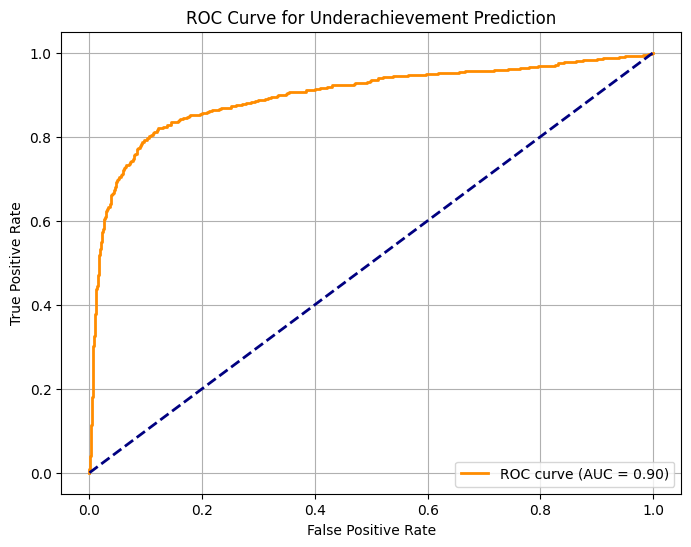

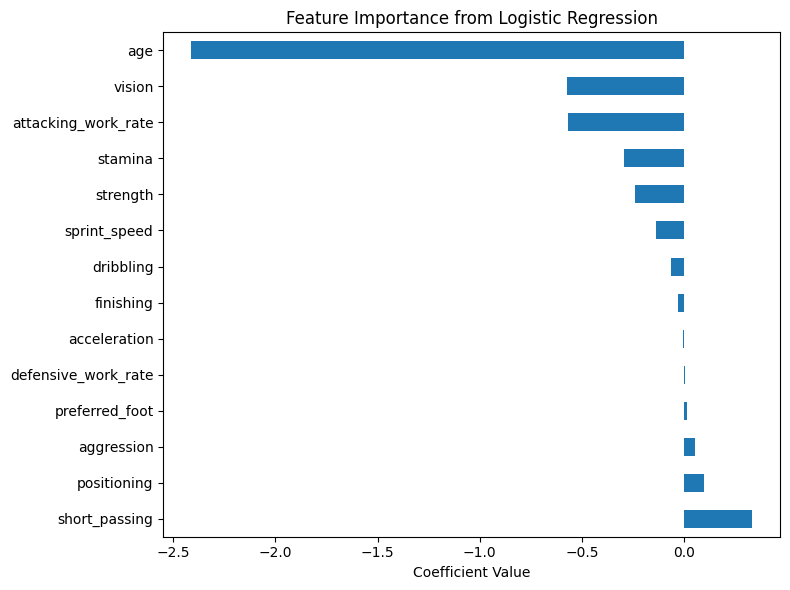

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# ROC Curve Plot
y_proba = model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Underachievement Prediction')
plt.legend(loc="lower right")
plt.grid(True)
plt.savefig('roc_curve.png', dpi=300, bbox_inches='tight')
plt.show()

# Feature Importance Plot
import seaborn as sns

plt.figure(figsize=(8, 6))
feature_importance.plot(kind='barh')
plt.xlabel('Coefficient Value')
plt.title('Feature Importance from Logistic Regression')
plt.tight_layout()
plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:35:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Logistic Regression ROC AUC: 0.8977651108160357
Random Forest ROC AUC: 0.9681865086541632
XGBoost ROC AUC: 0.9681367026076124


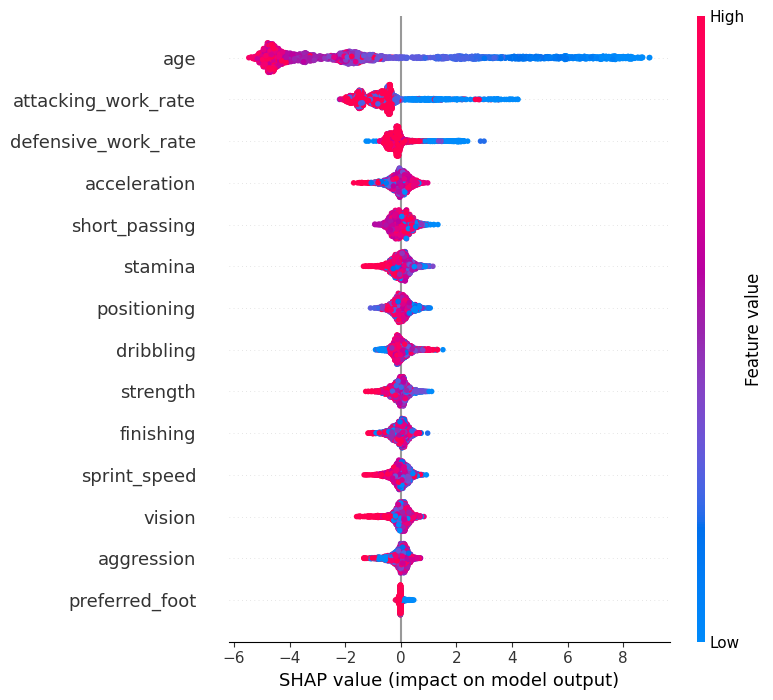

In [ ]:
!pip install shap xgboost scikit-learn pandas matplotlib seaborn

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import classification_report, roc_auc_score
import shap

# Load the data
conn = sqlite3.connect('/content/drive/MyDrive/Yoni/soccer/database.sqlite')
query = """
SELECT
    p.player_api_id, p.player_name, p.birthday,
    pa.date, pa.overall_rating, pa.potential, pa.preferred_foot,
    pa.attacking_work_rate, pa.defensive_work_rate,
    pa.vision, pa.aggression, pa.positioning,
    pa.acceleration, pa.sprint_speed, pa.stamina, pa.strength,
    pa.dribbling, pa.finishing, pa.short_passing
FROM Player_Attributes pa
JOIN Player p ON pa.player_api_id = p.player_api_id
WHERE pa.overall_rating IS NOT NULL AND pa.potential IS NOT NULL
"""
df = pd.read_sql_query(query, conn)
conn.close()

# Preprocessing
df['date'] = pd.to_datetime(df['date'])
df['birthday'] = pd.to_datetime(df['birthday'])
latest_df = df.sort_values('date').groupby('player_api_id').last().reset_index()
latest_df['age'] = (latest_df['date'] - latest_df['birthday']).dt.days / 365.25
latest_df['potential_gap'] = latest_df['potential'] - latest_df['overall_rating']
latest_df['underachiever'] = (latest_df['potential_gap'] >= 5).astype(int)

# Encode categorical variables
le = LabelEncoder()
latest_df['preferred_foot'] = le.fit_transform(latest_df['preferred_foot'].fillna('Unknown'))
latest_df['attacking_work_rate'] = le.fit_transform(latest_df['attacking_work_rate'].fillna('Unknown'))
latest_df['defensive_work_rate'] = le.fit_transform(latest_df['defensive_work_rate'].fillna('Unknown'))

features = [
    'age', 'preferred_foot', 'attacking_work_rate', 'defensive_work_rate',
    'vision', 'aggression', 'positioning',
    'acceleration', 'sprint_speed', 'stamina', 'strength',
    'dribbling', 'finishing', 'short_passing'
]

X = latest_df[features].fillna(0)
y = latest_df['underachiever']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Logistic Regression
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)
lr_pred = lr_model.predict(X_test)
lr_auc = roc_auc_score(y_test, lr_model.predict_proba(X_test)[:, 1])

# Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)
rf_auc = roc_auc_score(y_test, rf_model.predict_proba(X_test)[:, 1])

# XGBoost
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)
xgb_auc = roc_auc_score(y_test, xgb_model.predict_proba(X_test)[:, 1])

# Evaluation
print("Logistic Regression ROC AUC:", lr_auc)
print("Random Forest ROC AUC:", rf_auc)
print("XGBoost ROC AUC:", xgb_auc)

# SHAP Analysis for XGBoost
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, feature_names=features, show=False)
plt.savefig('shap_summary.png', bbox_inches='tight', dpi=300)
plt.show()


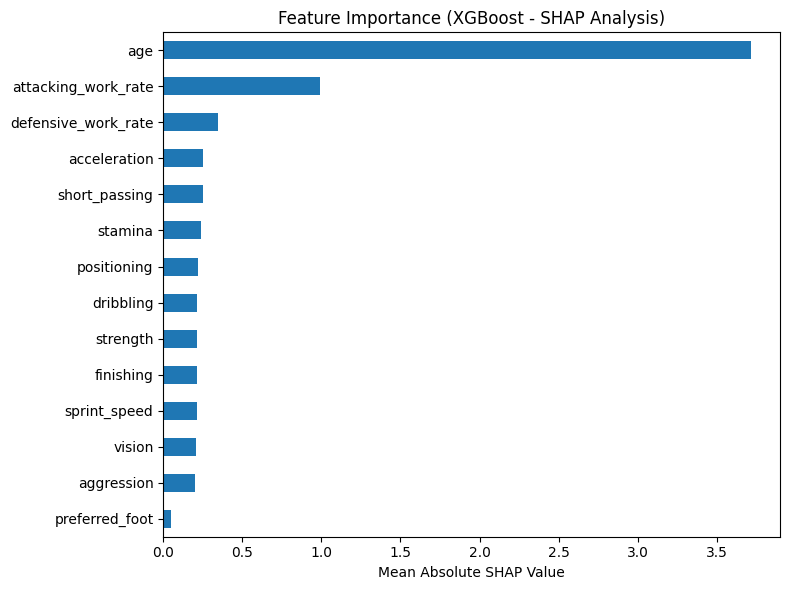

In [ ]:
# Calculate mean absolute SHAP values per feature
shap_values_array = np.array(shap_values)
mean_abs_shap = np.abs(shap_values_array).mean(axis=0)

# Create a pandas Series for better visualization
shap_importance = pd.Series(mean_abs_shap, index=features).sort_values(ascending=True)

# Plot
plt.figure(figsize=(8, 6))
shap_importance.plot(kind='barh', color='#1f77b4')
plt.xlabel('Mean Absolute SHAP Value')
plt.title('Feature Importance (XGBoost - SHAP Analysis)')
plt.tight_layout()
plt.savefig('shap_bar_plot.png', dpi=300, bbox_inches='tight')
plt.show()


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:43:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


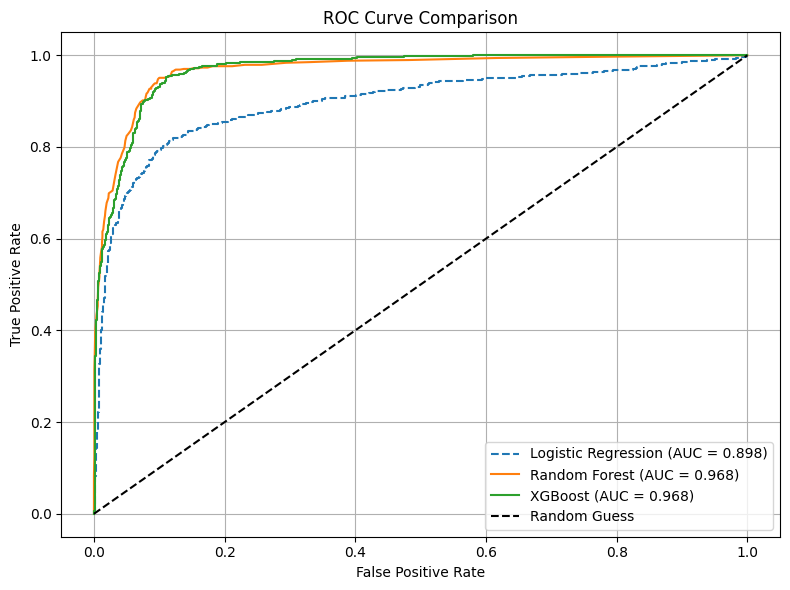

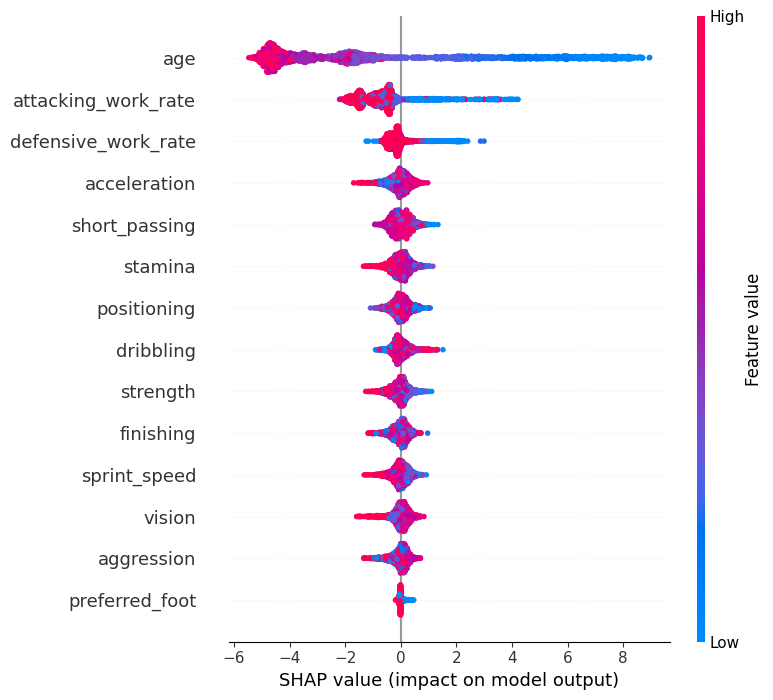

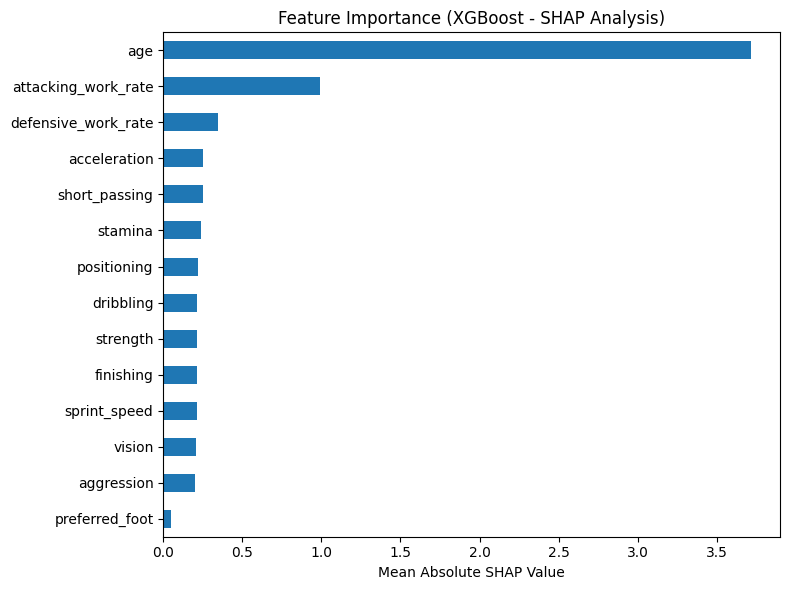

Logistic Regression ROC AUC: 0.8977651108160357
Random Forest ROC AUC: 0.9681865086541632
XGBoost ROC AUC: 0.9681367026076124


In [ ]:
import pandas as pd
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc
import shap

# Load Data
conn = sqlite3.connect('/content/drive/MyDrive/Yoni/soccer/database.sqlite')
query = """
SELECT
    p.player_api_id, p.player_name, p.birthday,
    pa.date, pa.overall_rating, pa.potential, pa.preferred_foot,
    pa.attacking_work_rate, pa.defensive_work_rate,
    pa.vision, pa.aggression, pa.positioning,
    pa.acceleration, pa.sprint_speed, pa.stamina, pa.strength,
    pa.dribbling, pa.finishing, pa.short_passing
FROM Player_Attributes pa
JOIN Player p ON pa.player_api_id = p.player_api_id
WHERE pa.overall_rating IS NOT NULL AND pa.potential IS NOT NULL
"""
df = pd.read_sql_query(query, conn)
conn.close()

# Preprocessing
df['date'] = pd.to_datetime(df['date'])
df['birthday'] = pd.to_datetime(df['birthday'])
latest_df = df.sort_values('date').groupby('player_api_id').last().reset_index()
latest_df['age'] = (latest_df['date'] - latest_df['birthday']).dt.days / 365.25
latest_df['potential_gap'] = latest_df['potential'] - latest_df['overall_rating']
latest_df['underachiever'] = (latest_df['potential_gap'] >= 5).astype(int)

le = LabelEncoder()
latest_df['preferred_foot'] = le.fit_transform(latest_df['preferred_foot'].fillna('Unknown'))
latest_df['attacking_work_rate'] = le.fit_transform(latest_df['attacking_work_rate'].fillna('Unknown'))
latest_df['defensive_work_rate'] = le.fit_transform(latest_df['defensive_work_rate'].fillna('Unknown'))

features = [
    'age', 'preferred_foot', 'attacking_work_rate', 'defensive_work_rate',
    'vision', 'aggression', 'positioning',
    'acceleration', 'sprint_speed', 'stamina', 'strength',
    'dribbling', 'finishing', 'short_passing'
]

X = latest_df[features].fillna(0)
y = latest_df['underachiever']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Logistic Regression
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)
lr_probs = lr_model.predict_proba(X_test)[:, 1]

# Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
rf_probs = rf_model.predict_proba(X_test)[:, 1]

# XGBoost
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)
xgb_probs = xgb_model.predict_proba(X_test)[:, 1]

# ROC Curve
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_probs)
xgb_fpr, xgb_tpr, _ = roc_curve(y_test, xgb_probs)

plt.figure(figsize=(8, 6))
plt.plot(lr_fpr, lr_tpr, '--', label=f'Logistic Regression (AUC = {auc(lr_fpr, lr_tpr):.3f})')
plt.plot(rf_fpr, rf_tpr, label=f'Random Forest (AUC = {auc(rf_fpr, rf_tpr):.3f})')
plt.plot(xgb_fpr, xgb_tpr, label=f'XGBoost (AUC = {auc(xgb_fpr, xgb_tpr):.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.savefig('roc_curve.png', dpi=300, bbox_inches='tight')
plt.show()

# SHAP Analysis for XGBoost
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test)

# SHAP Summary Plot (Beeswarm)
shap.summary_plot(shap_values, X_test, feature_names=features, show=False)
plt.savefig('shap_summary.png', dpi=300, bbox_inches='tight')
plt.show()

# SHAP Bar Plot (Mean Absolute SHAP Values)
mean_abs_shap = np.abs(np.array(shap_values)).mean(axis=0)
shap_importance = pd.Series(mean_abs_shap, index=features).sort_values(ascending=True)

plt.figure(figsize=(8, 6))
shap_importance.plot(kind='barh', color='#1f77b4')
plt.xlabel('Mean Absolute SHAP Value')
plt.title('Feature Importance (XGBoost - SHAP Analysis)')
plt.tight_layout()
plt.savefig('shap_bar_plot.png', dpi=300, bbox_inches='tight')
plt.show()

# Final Results
print("Logistic Regression ROC AUC:", roc_auc_score(y_test, lr_probs))
print("Random Forest ROC AUC:", roc_auc_score(y_test, rf_probs))
print("XGBoost ROC AUC:", roc_auc_score(y_test, xgb_probs))


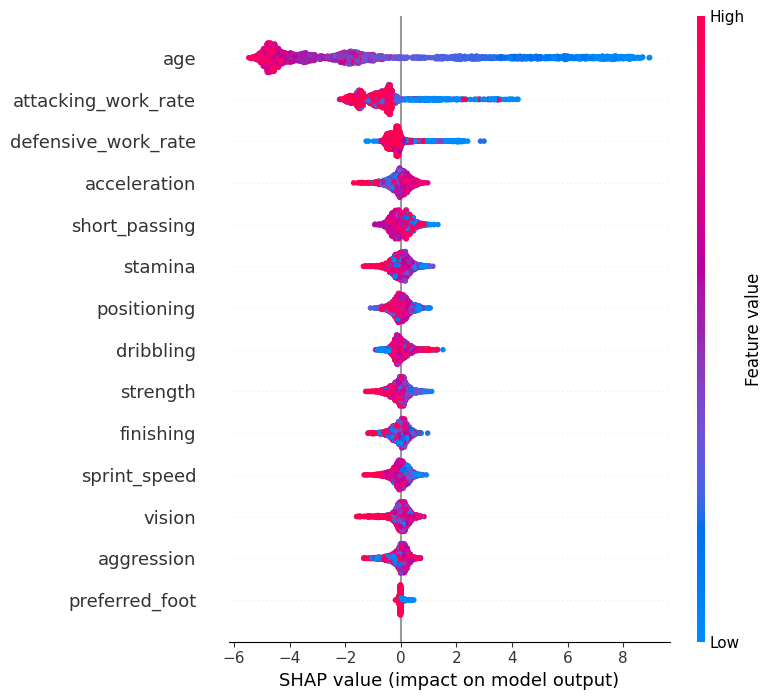

In [ ]:
import shap
import matplotlib.pyplot as plt

# Assuming xgb_model and X_test are already defined

# SHAP Analysis
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test)

# Create SHAP Summary Plot (Beeswarm)
shap.summary_plot(shap_values, X_test, feature_names=features, show=False)
plt.savefig('shap_summary.png', dpi=300, bbox_inches='tight')
plt.show()


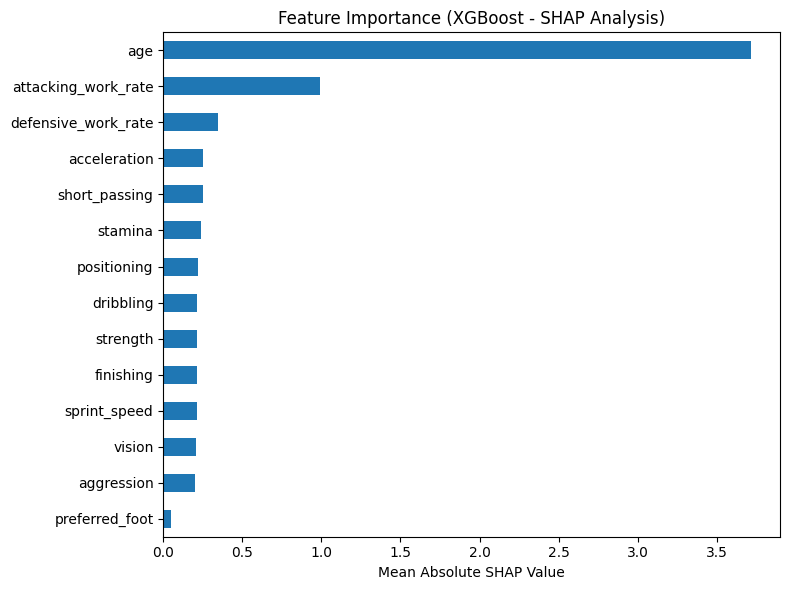

In [ ]:


# Assuming shap_values, X_test, and features are already defined

# Calculate Mean Absolute SHAP Values per Feature
shap_values_array = np.array(shap_values)
mean_abs_shap = np.abs(shap_values_array).mean(axis=0)

# Create Pandas Series for Plotting
shap_importance = pd.Series(mean_abs_shap, index=features).sort_values(ascending=True)

# Plot SHAP Feature Importance Bar Plot
plt.figure(figsize=(8, 6))
shap_importance.plot(kind='barh', color='#1f77b4')
plt.xlabel('Mean Absolute SHAP Value')
plt.title('Feature Importance (XGBoost - SHAP Analysis)')
plt.tight_layout()
plt.savefig('shap_bar_plot.png', dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline

# Assuming your processed DataFrame is 'latest_df' with:
# - Features in 'X'
# - Target in 'y' (underachiever: 1, expected achiever: 0)

features = [
    'age', 'preferred_foot', 'attacking_work_rate', 'defensive_work_rate',
    'vision', 'aggression', 'positioning',
    'acceleration', 'sprint_speed', 'stamina', 'strength',
    'dribbling', 'finishing', 'short_passing'
]

X = latest_df[features].fillna(0)
y = latest_df['underachiever']

# Encode categorical variables
le_foot = LabelEncoder()
le_work_att = LabelEncoder()
le_work_def = LabelEncoder()

X['preferred_foot'] = le_foot.fit_transform(X['preferred_foot'].astype(str))
X['attacking_work_rate'] = le_work_att.fit_transform(X['attacking_work_rate'].astype(str))
X['defensive_work_rate'] = le_work_def.fit_transform(X['defensive_work_rate'].astype(str))

# Define models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

# Use Stratified K-Fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Evaluate each model
for name, model in models.items():
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', model)
    ])

    auc_scores = cross_val_score(
        pipeline, X, y, cv=skf, scoring='roc_auc', n_jobs=-1
    )

    print(f'{name} | Mean ROC AUC: {auc_scores.mean():.4f} | Std: {auc_scores.std():.4f}')


Logistic Regression | Mean ROC AUC: 0.9070 | Std: 0.0059
Random Forest | Mean ROC AUC: 0.9668 | Std: 0.0031
XGBoost | Mean ROC AUC: 0.9668 | Std: 0.0024
